In [1]:
# standard libraries
import re, gzip, os, platform
from io import StringIO

# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm
import sklearn.ensemble
import sklearn.metrics
import requests

## Read data and data pre-processing

In [2]:
if platform.system() == 'Linux':
    projectDir = os.path.join(os.environ['HOME'], 'projects', 'IDP_PPI_Prediction')
else:
    projectDir = 'D:\\OneDrive\\Documents\\College (Stanford)\\2018-19 Coterm\\Q1 Autumn\\CS 229\\Project\\IDP_PPI_Prediction'
projectDir

In [3]:
# Script parameters
# - save: bool
#     Save processed data or just read data
# - compression: str (e.g., 'gzip')
#     Compression to apply when saving processed data files. Set to None to disable
# - show_df: bool
#     Display DataFrames in the notebook after reading and processing data
# - save_kwargs: dict
#     Common arguments to pass to pandas.DataFrame.to_csv() when saving processed data

save = True
compression = 'gzip'
show_df = False
save_kwargs = {'sep': '\t', 'index': False, 'compression': compression}

In [4]:
# raw data file names
dirDataRaw = os.path.join(projectDir, 'data', 'raw')
raw_datasets = os.path.join(dirDataRaw, '41598_2018_28815_MOESM2_ESM.xlsx')
raw_proteome = os.path.join(dirDataRaw, 'UP000005640_9606.fasta.gz')
raw_hippie = os.path.join(dirDataRaw, 'hippie_current.txt.gz')
raw_disprot = os.path.join(dirDataRaw, 'disprot.csv.gz')

# processed data file names
ext = ('' if compression is None else '.gz')
dirDataProc = os.path.join(projectDir, 'data', 'proc')
proc_trainsets = os.path.join(dirDataProc, 'trainset{:02d}.tsv' + ext)
proc_testsets = os.path.join(dirDataProc, 'testset{:02d}.tsv' + ext)
proc_proteome = os.path.join(dirDataProc, 'UP000005640_9606.tsv' + ext)
proc_hippie = os.path.join(dirDataProc, 'hippie.tsv' + ext)
proc_disprot = os.path.join(dirDataProc, 'disprot.tsv' + ext)

Datasets (training and test) from [Perovic et al.](https://doi.org/10.1038/s41598-018-28815-x)

In [ ]:
xlsx = pd.ExcelFile(raw_datasets)
num_datasets = 5
for i in range(num_datasets):
    # many sheet names have trailing whitespace
    train_sheet_name = 'Table S' + str(i+7) + '-DisorderTrainSet' + str(i+1)
    train_sheet_name = np.where([name.startswith(train_sheet_name) for name in xlsx.sheet_names])[0][0]
    test_sheet_name = 'Table S' + str(i+12) + '-DisorderTestSet' + str(i+1)
    test_sheet_name = np.where([name.startswith(test_sheet_name) for name in xlsx.sheet_names])[0][0]
    
    trainset = pd.read_excel(xlsx, sheet_name=train_sheet_name)
    trainset = trainset.iloc[:,0].str.split(expand=True)
    trainset.columns = ['label', 'p1_uniprotName', 'p2_uniprotName']
    
    testset = pd.read_excel(xlsx, sheet_name=test_sheet_name)
    testset = testset.iloc[:,0].str.split(expand=True)
    testset.columns = ['label', 'p1_uniprotName', 'p2_uniprotName']
    
    if save:
        trainset.to_csv(proc_trainsets.format(i+1), **save_kwargs)
        testset.to_csv(proc_testsets.format(i+1), **save_kwargs)
del xlsx

Hippie database: protein-protein interactions

In [ ]:
db_hippie = pd.read_csv(raw_hippie, sep='\t', header=None)
db_hippie.columns = ['p1_uniprotName', 'p1_entrezID', 'p2_uniprotName', 'p2_entrezID', 'score', 'evidence']
if save:
    db_hippie.to_csv(proc_hippie, **save_kwargs)
if show_df:
    display(db_hippie)

Disprot database: protein disorder

In [ ]:
db_disprot = pd.read_csv(raw_disprot)

# map UniProt accession values (e.g., 'O14832') to UniProt entry names (aka UniProt IDs) (e.g., 'PAHX_HUMAN')
url = 'https://www.uniprot.org/uploadlists/'
params = {
    'from': 'ACC',
    'to': 'ID',
    'format': 'tab',
    'query': ' '.join(db_disprot['uniprot_accession'].values.tolist())
}
r = requests.post(url, data = params)
uniprotIdToName = pd.read_csv(StringIO(r.text), sep='\t', index_col='From')

db_disprot['uniprot_name'] = uniprotIdToName.loc[db_disprot['uniprot_accession'], 'To'].values
if save:
    db_disprot.to_csv(proc_disprot, **save_kwargs)
if show_df:
    display(db_disprot)

UniProt database: canonical protein sequences

In [ ]:
def parseUniProtHeader(header, header_prefix='>'):
    '''
    Parse UniProt FASTA header. See https://www.uniprot.org/help/fasta-headers.
    
    Args:
    - header: str
        FASTA header line
    - header_prefix: str. default='>'
        FASTA header line prefix
    
    Returns: dict
      Map of metadata of protein sequence.
      Keys: db, id, uniprotName, proteinName, os, ox, gn (may be empty), pe, sv
    '''
    
    # strip whitespace and prefix
    header = header.strip()
    if header.startswith(header_prefix):
        header = header[len(header_prefix):]
    
    # extract gene name if present
    split = re.split(r'GN=(?P<gn>.*)(?=\sPE=)\s+', header)
    m_gn = ''
    if len(split) not in [1,3]:
        raise
    if len(split) > 1:
        m_gn = split[1]
        header = split[0] + split[2]
    
    # extract other variables
    p = re.compile(r'(?P<db>sp|tr)\|(?P<id>[^|]+)\|(?P<uniprotName>\S+)\s+'
                   + r'(?P<proteinName>.*(?=\sOS=)) '
                   + r'OS=(?P<os>.*(?=\sOX=))\s+'
                   + r'OX=(?P<ox>.*(?=\sPE=))\s+'
                   + r'PE=(?P<pe>.*(?=\sSV=))\s+'
                   + r'SV=(?P<sv>.*)')
    m = p.match(header)
    
    # extract regex match to dict
    data = m.groupdict()
    
    # add gene name if present
    data['gn'] = m_gn
    
    # remove leading/trailing whitespace from each value in dict
    data = {key: value.strip() for key, value in data.items()}
    
    return data

def fastaToDF(file, save='', header_prefix='>', headerParser=parseUniProtHeader, **kwargs):
    '''
    Parse FASTA file into pandas DataFrame.
    
    Args:
    - file: str
        Path to FASTA file. Gzip-compressed files (i.e., with extension '.gz') are accepted.
    - save: str. default=''
        Path to save DataFrame
    - header_prefix: str. default='>'
        FASTA header line prefix
    - headerParser: function. default = parseUniProtHeader
        Function to parse header line into dict
    - **kwargs
        Additional keyword arguments to pass to pandas.DataFrame.to_csv() if saving DataFrame.
    
    Returns: pandas.DataFrame
      Rows: protein / DNA entries
      Columns: data about entries. Always includes 'seq' (sequence) column.
    '''
    
    if file.endswith('.gz'):
        f = gzip.open(file, mode='rt')
    else:
        f = open(file)
    
    entries = []
    entry = {'seq': ''}
    while True:
        # read 1 line at a time to avoid memory overflow
        line = f.readline()

        if line == '':
            break

        if line.startswith(header_prefix):
            # add previous entry to running list of entries
            if entry['seq'] is not '':
                # add sequence to entry
                entries.append(entry)
            
            # parse new entry
            entry = headerParser(line)
            entry['seq'] = ''
        else:
            entry['seq'] += line.strip()
    f.close()
    
    df = pd.DataFrame(entries)
    if save is not '':
        df.to_csv(save, **kwargs)
    
    # construct pandas DataFrame from list of dicts
    return pd.DataFrame(entries)

db_uniprot = fastaToDF(raw_proteome, save=(proc_proteome if save else ''), **save_kwargs)
if show_df:
    display(db_uniprot)

## Featurization

Requires R package protr

## Training

In [5]:
regex_train_features = re.compile(r'train_features\d+')
regex_train_labels = re.compile(r'train_labels\d+')
regex_test_features = re.compile(r'test_features\d+')
regex_test_labels = re.compile(r'test_labels\d+')

datasets_train = list(zip(list(filter(regex_train_features.match, os.listdir(dirDataProc))),
                          list(filter(regex_train_labels.match, os.listdir(dirDataProc)))))
datasets_test = list(zip(list(filter(regex_test_features.match, os.listdir(dirDataProc))),
                         list(filter(regex_test_labels.match, os.listdir(dirDataProc)))))
display(datasets_train)
display(datasets_test)

[('train_features01.tsv.gz', 'train_labels01.txt.gz'),
 ('train_features02.tsv.gz', 'train_labels02.txt.gz'),
 ('train_features03.tsv.gz', 'train_labels03.txt.gz'),
 ('train_features04.tsv.gz', 'train_labels04.txt.gz'),
 ('train_features05.tsv.gz', 'train_labels05.txt.gz')]

[('test_features01.tsv.gz', 'test_labels01.txt.gz'),
 ('test_features02.tsv.gz', 'test_labels02.txt.gz'),
 ('test_features03.tsv.gz', 'test_labels03.txt.gz'),
 ('test_features04.tsv.gz', 'test_labels04.txt.gz'),
 ('test_features05.tsv.gz', 'test_labels05.txt.gz')]

In [6]:
def fitAndEval(X_train, Y_train, X_test, Y_test, model):
    model.fit(X_train, Y_train)
    if hasattr(model, "decision_function") and callable(model.decision_function):
        y_score = model.decision_function(X_test)
    elif hasattr(model, "predict_proba") and callable(model.predict_proba):
        y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = sklearn.metrics.roc_curve(Y_test, y_score)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    return (fpr, tpr, thresh, roc_auc)

C:\Users\benty\Miniconda3\envs\py37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


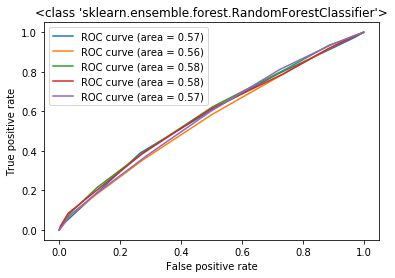

In [19]:
# models = [sklearn.svm.LinearSVC(), sklearn.svm.SVC(), sklearn.ensemble.RandomForestClassifier()]
models = [sklearn.ensemble.RandomForestClassifier()]
for model in models:
    plt.figure()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(type(model))
    for i in range(len(datasets_train)):
        X_train_file, Y_train_file = datasets_train[i]
        X_test_file, Y_test_file = datasets_test[i]

        X_train = pd.read_csv(os.path.join(dirDataProc, X_train_file), sep='\t', header=0).values
        Y_train = pd.read_csv(os.path.join(dirDataProc, Y_train_file), sep='\t', header=None).squeeze().values
        X_test = pd.read_csv(os.path.join(dirDataProc, X_test_file), sep='\t', header=0).values
        Y_test = pd.read_csv(os.path.join(dirDataProc, Y_test_file), sep='\t', header=None).squeeze().values
        
        fpr, tpr, thresh, roc_auc = fitAndEval(X_train, Y_train, X_test, Y_test, model)
        plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.legend()
plt.show()